In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
print(tf.__version__)

/anaconda3/envs/dlcv/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


2.0.0


In [3]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

## Trend and Seasonality

In [4]:
def trend(time, slope=0):
    return slope * time

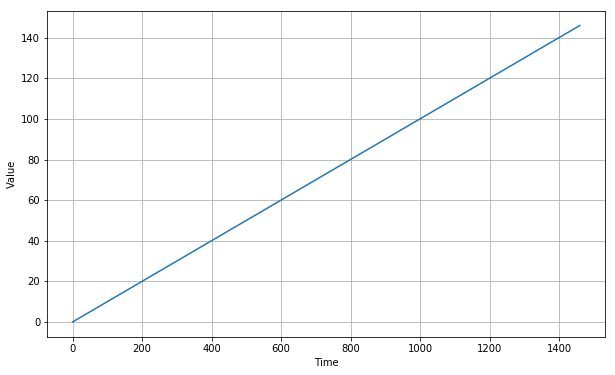

In [5]:
time = np.arange(4 * 365 + 1)
baseline = 10
series = trend(time, 0.1)

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

### Seasonal Pattern

In [6]:
def seasonal_pattern(season_time):
    """
    Just an arbitrary pattern, you can change it if you wish
    """
    return np.where(
        season_time < 0.4,
        np.cos(season_time * 2 * np.pi),
        1 / np.exp(3 * season_time)
    )
    
def seasonality(time, period, amplitude=1, phase=0):
    """
    Repeats the same pattern at each period
    """
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)


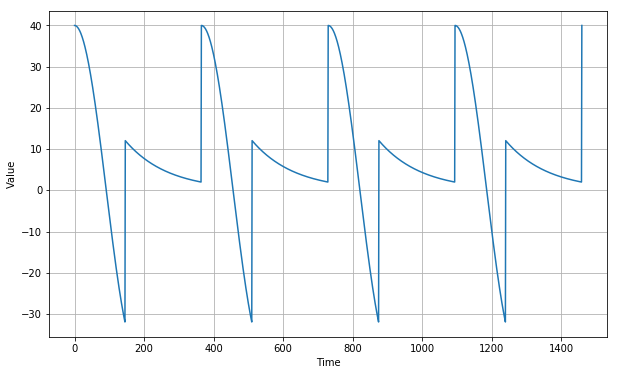

In [7]:
baseline = 10
amplitude = 40

series = seasonality(time, period=365, amplitude=amplitude)

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

### Trend + Seasonality

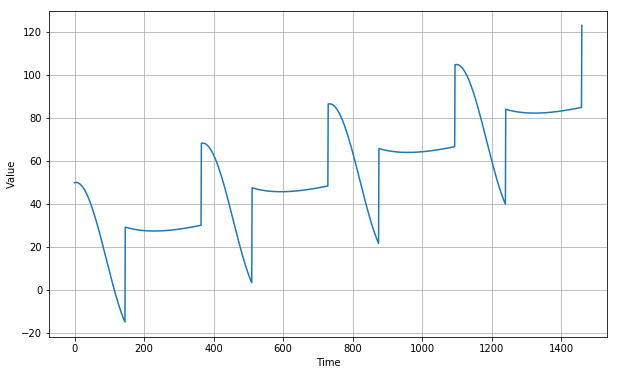

In [8]:
slope = 0.05
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

### Noise

In [9]:
def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

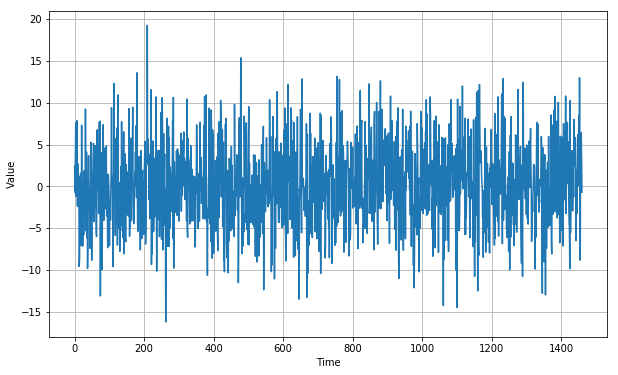

In [11]:
noise_level = 5
noise = white_noise(time, noise_level, seed=42)

plt.figure(figsize=(10, 6))
plot_series(time, noise)
plt.show()

### Trend + Noise

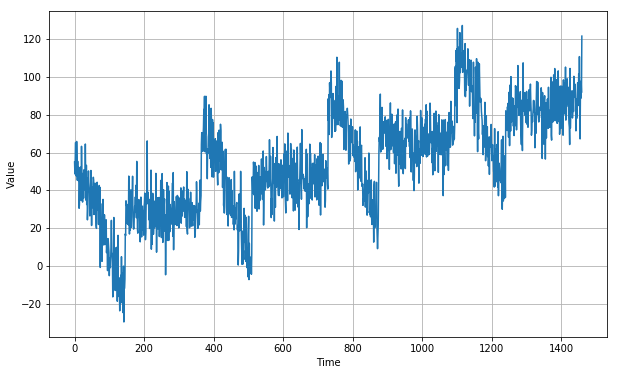

In [13]:
series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

## Forecast

In [15]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [17]:
def autocorrelation_multi(time, amplitude, seed=None):
    rnd = np.random.RandomState(seed)
    φ1 = 0.5
    φ2 = -0.1
    ar = rnd.randn(len(time) + 50)
    ar[:50] = 100
    for step in range(50, len(time) + 50):
        ar[step] += φ1 * ar[step - 50]
        ar[step] += φ2 * ar[step - 33]
        
    return ar[50:] * amplitude

def autocorrelation_uni(time, amplitude, seed=None):
    rnd = np.random.RandomState(seed)
    φ = 0.8
    ar = rnd.randn(len(time) + 1)
    for step in range(1, len(time) + 1):
        ar[step] += φ * ar[step - 1]
    return ar[1:] * amplitude

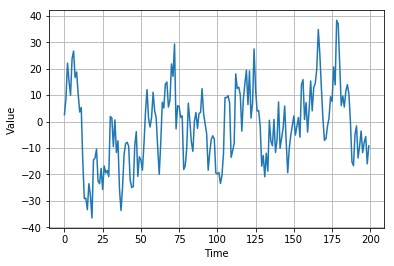

In [18]:
series = autocorrelation_uni(time, 10, seed=42)
plot_series(time[:200], series[:200])
plt.show()

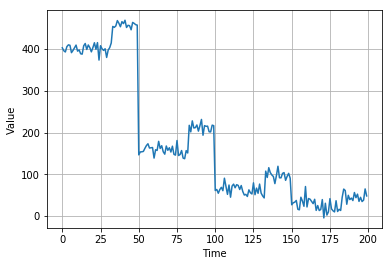

In [19]:
series = autocorrelation_multi(time, 10, seed=42)
plot_series(time[:200], series[:200])
plt.show()

### Autocorrelation + Trend

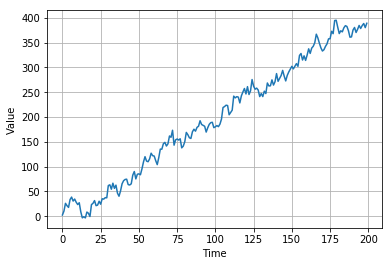

In [20]:
series = autocorrelation_uni(time, 10, seed=42) + trend(time, 2)
plot_series(time[:200], series[:200])
plt.show()

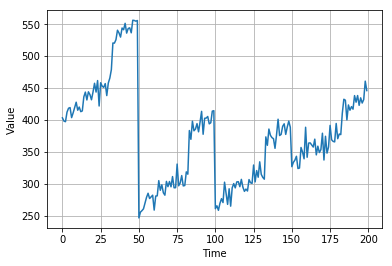

In [21]:
series = autocorrelation_multi(time, 10, seed=42) + trend(time, 2)
plot_series(time[:200], series[:200])
plt.show()

### Autocorrelation + Trend + Seasonality

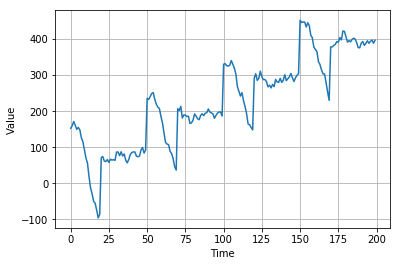

In [22]:
series = autocorrelation_uni(time, 10, seed=42) + trend(time, 2) + seasonality(time, period=50, amplitude=150)
plot_series(time[:200], series[:200])
plt.show()

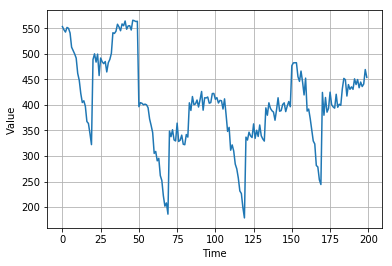

In [23]:
series = autocorrelation_multi(time, 10, seed=42) + trend(time, 2) + seasonality(time, period=50, amplitude=150)
plot_series(time[:200], series[:200])
plt.show()

### 2 Autocorrelation + Seasonality + Trend

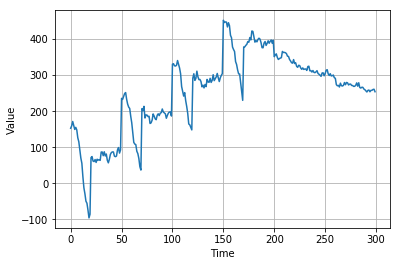

In [30]:
series = autocorrelation_uni(time, 10, seed=42) + trend(time, 2) + seasonality(time, period=50, amplitude=150)
series2 = autocorrelation_uni(time, 5, seed=42) + seasonality(time, period=50, amplitude=2) + trend(time, -1)  + 550
series[200:] = series2[200:]
plot_series(time[:300], series[:300])
plt.show()

### Impulses

In [31]:
def impulses(time, num_impulses, amplitude=1, seed=None):
    rnd = np.random.RandomState(seed)
    impulse_indices = rnd.randint(len(time), size=10)
    series = np.zeros(len(time))
    for index in impulse_indices:
        series[index] += rnd.rand() * amplitude
    return series

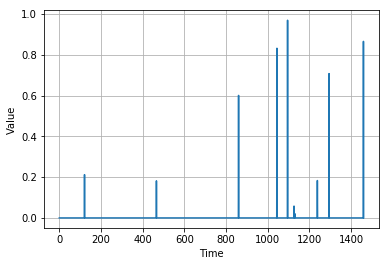

In [32]:
series = impulses(time, 10, seed=42)
plot_series(time, series)
plt.show()

In [33]:
def autocorrelation(source, φs):
    ar = source.copy()
    max_lag = len(φs)
    for step, value in enumerate(source):
        for lag, φ in φs.items():
            if step - lag > 0:
                ar[step] += φ * ar[step - lag]
    return ar

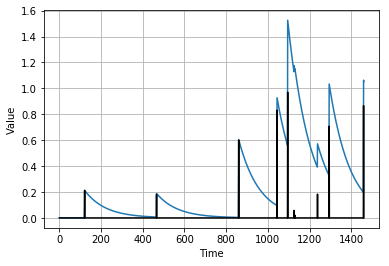

In [36]:
signal = impulses(time, 10, seed=42)
series = autocorrelation(signal, {
    1: 0.99
})
plot_series(time, series)
plt.plot(time, signal, "k-")
plt.show()

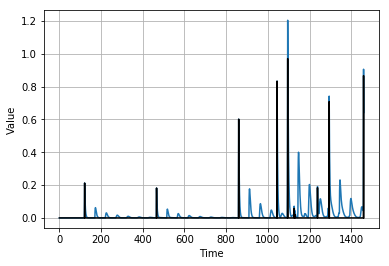

In [37]:
signal = impulses(time, 10, seed=42)
series = autocorrelation(signal, {
    1: 0.70, 50: 0.2
})
plot_series(time, series)
plt.plot(time, signal, "k-")
plt.show()

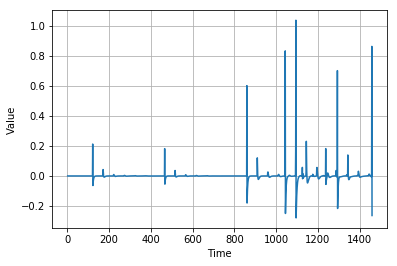

In [38]:
series_diff1 = series[1:] - series[:-1]
plot_series(time[1:], series_diff1)

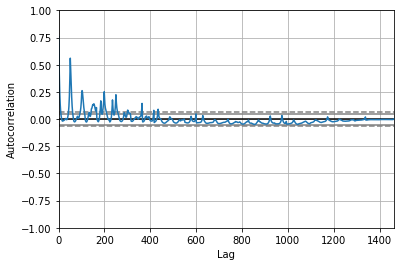

In [39]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(series)

In [40]:
from statsmodels.tsa.arima_model import ARIMA

/anaconda3/envs/dlcv/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [42]:
model = ARIMA(series, order=(5, 1, 0))
model_fit = model.fit(disp=0)
print(model_fit.summary())

/anaconda3/envs/dlcv/lib/python3.6/site-packages/scipy/signal/signaltools.py:1333: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/anaconda3/envs/dlcv/lib/python3.6/site-packages/scipy/signal/signaltools.py:1336: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/anaconda3/envs/dlcv/lib/python3.6/site-packages/scipy/signal/signaltools.py:1342: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be inte

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                 1460
Model:                 ARIMA(5, 1, 0)   Log Likelihood                2223.428
Method:                       css-mle   S.D. of innovations              0.053
Date:                Sun, 06 Oct 2019   AIC                          -4432.855
Time:                        12:52:28   BIC                          -4395.852
Sample:                             1   HQIC                         -4419.052
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.001      0.384      0.701      -0.001       0.002
ar.L1.D.y     -0.1235      0.026     -4.714      0.000      -0.175      -0.072
ar.L2.D.y     -0.1254      0.029     -4.333      0.0

/anaconda3/envs/dlcv/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
